In [59]:
import numpy as np
import matplotlib.pyplot as plt
import quantities as pq
import neo
import elephant 
import viziphant

## Generate a gamma process

In [60]:
# Regularity defined by `shape_factor`: higher values -> more clock-like
rate = 20*pq.Hz
gamma_shape_factor = 20
duration = 60*pq.s

gamma_process = elephant.spike_train_generation.StationaryGammaProcess(
    rate=rate, 
    shape_factor=gamma_shape_factor,
    t_start=0*pq.ms,
    t_stop=duration)

st = gamma_process.generate_spiketrain()

In [61]:
# Show resulting SpikeTrain
st

SpikeTrain containing 1200 spikes; units s; datatype float64 
time: 0.0 s to 60.0 s

## Plot the first seconds of the spike train

<Axes: xlabel='Time (s)'>

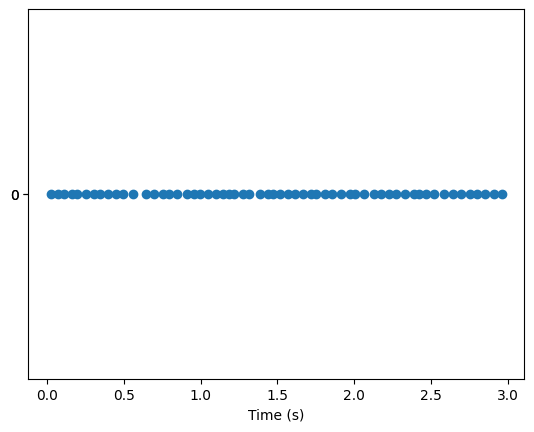

In [62]:
# Slice spike train to first few seconds before plotting
viziphant.rasterplot.rasterplot(
    [st.time_slice(t_start=0*pq.ms, t_stop=3000*pq.ms)])

## Create a binned representation of the spike train

In [63]:
bin_size = 1*pq.ms
bst = elephant.conversion.BinnedSpikeTrain(
    st, bin_size=bin_size)

In [64]:
# Show dimensions of the spike train
assert(bst.to_array().shape[1] == (duration/bin_size).simplified.magnitude)
bst.to_array().shape

(1, 60000)

## Convert binned spike train object to a time series object

In [65]:
binned_spikes_timeseries = neo.AnalogSignal(
    bst.to_array().transpose()/bst.bin_size.magnitude*pq.dimensionless, 
    t_start=bst.t_start, 
    sampling_period=bst.bin_size)

## Create a Welch PSD estimate

In [66]:
# Convert binned spike train to an Analog Signal in order to retain the units
f_w,psd_w = elephant.spectral.welch_psd(
    binned_spikes_timeseries, n_segments=10, overlap=0)

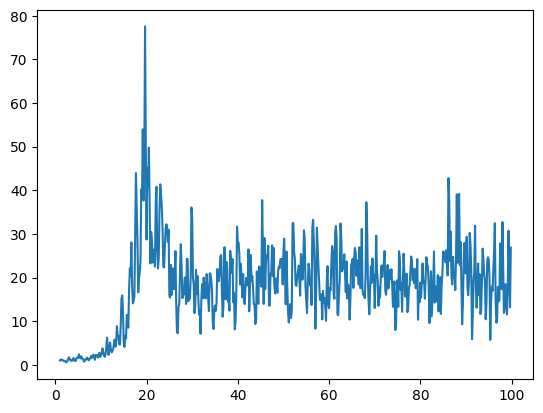

In [67]:
# Limit frequency axis to 1-100 Hz
lower_f_index = np.searchsorted(f_w.rescale(pq.Hz).magnitude, 1)
upper_f_index = np.searchsorted(f_w.rescale(pq.Hz).magnitude, 100)
plt.plot(f_w[lower_f_index:upper_f_index], np.transpose(psd_w[0, lower_f_index:upper_f_index]/2))

In [68]:
# Check average power in tail
lower_f_index = np.where(f_w>50)[0][0]
upper_f_index = np.where(f_w>100)[0][0]
np.mean(np.transpose(psd_w[0,lower_f_index:upper_f_index])/2)

array(20.10228473) * 1/Hz

## Create a multitaper PSD estimate

In [69]:
# Convert binned spike train to an Analog Signal in order to retain the units
f_mt, psd_mt = elephant.spectral.multitaper_psd(
    binned_spikes_timeseries)

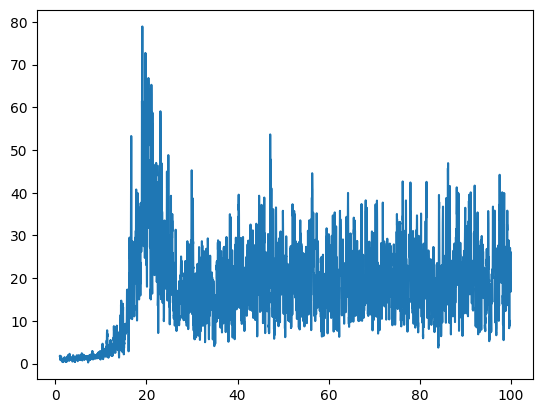

In [70]:
# Limit frequency axis to 1-100 Hz
lower_f_index = np.searchsorted(f_mt.rescale(pq.Hz).magnitude, 1)
upper_f_index = np.searchsorted(f_mt.rescale(pq.Hz).magnitude, 100)
plt.plot(f_mt[lower_f_index:upper_f_index], np.transpose(psd_mt[0, lower_f_index:upper_f_index]/2))

In [71]:
# Check average power in tail
lower_f_index = np.where(f_mt>50)[0][0]
upper_f_index = np.where(f_mt>100)[0][0]
np.mean(np.transpose(psd_mt[0,lower_f_index:upper_f_index])/2)

array(20.04428065) * 1/Hz

## Create a multi-segment averaged multitaper PSD estimate

In [72]:
# Convert binned spike train to an Analog Signal in order to retain the units
f_mtn, psd_mtn = elephant.spectral.segmented_multitaper_psd(
    binned_spikes_timeseries, n_segments=10)

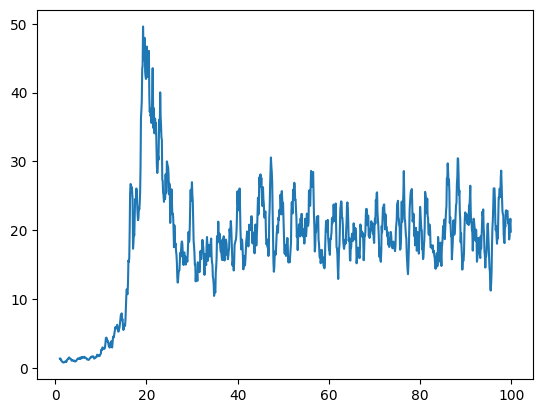

In [73]:
# Limit frequency axis to 1-100 Hz
lower_f_index = np.searchsorted(f_mtn.rescale(pq.Hz).magnitude, 1)
upper_f_index = np.searchsorted(f_mtn.rescale(pq.Hz).magnitude, 100)
plt.plot(f_mtn[lower_f_index:upper_f_index], np.transpose(psd_mtn[0, 0, lower_f_index:upper_f_index]/2))

## Bos spectra

In [74]:
# This is the power spectrum code found for Bos et al., 2018, https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005132
def powerspec(data, tbin, Df=None, units=False, N=None):
    '''
    Calculate (smoothed) power spectra of all timeseries in data. 
    If units=True, power spectra are averaged across units.
    Note that averaging is done on power spectra rather than data.

    Power spectra are normalized by the length T of the time series -> no scaling with T. 
    For a Poisson process this yields:

    **Args**:
       data: numpy.ndarray; 1st axis unit, 2nd axis time
       tbin: float; binsize in ms
       Df: float/None; window width of sliding rectangular filter (smoothing), None -> no smoothing
       units: bool; average power spectrum 

    **Return**:
       (freq, POW): tuple
       freq: numpy.ndarray; frequencies
       POW: if units=False: 2 dim numpy.ndarray; 1st axis unit, 2nd axis frequency
            if units=True:  1 dim numpy.ndarray; frequency series

    **Examples**:
       >>> powerspec(np.array([analog_sig1,analog_sig2]),tbin, Df=Df)
       Out[1]: (freq,POW)
       >>> POW.shape
       Out[2]: (2,len(analog_sig1))

       >>> powerspec(np.array([analog_sig1,analog_sig2]),tbin, Df=Df, units=True)
       Out[1]: (freq,POW)
       >>> POW.shape
       Out[2]: (len(analog_sig1),)

    '''
    if N is None:
        N = len(data)
    freq, DATA = calculate_fft(data, tbin)
    df = freq[1] - freq[0]
    T = tbin * len(freq)
    POW = np.power(np.abs(DATA),2)
    if Df is not None:
        POW = [movav(x, Df, df) for x in POW]
        cut = int(Df / df)
        freq = freq[cut:]
        POW = np.array([x[cut:] for x in POW])
        POW = np.abs(POW)
    assert(len(freq) == len(POW[0]))
    if units is True:
        POW = 1./N*np.sum(POW, axis=0)
        assert(len(freq) == len(POW))
    POW *= 1. / T * 1e3  # normalization, power independent of T
    return freq, POW


def calculate_fft(data, tbin):
    '''
    calculate the fouriertransform of data
    [tbin] = ms
    '''
    if len(np.shape(data)) > 1:
        n = len(data[0])
        return np.fft.fftfreq(n, tbin * 1e-3), np.fft.fft(data, axis=1)
    else:
        n = len(data)
        return np.fft.fftfreq(n, tbin * 1e-3), np.fft.fft(data)

def movav(y, Dx, dx):
    '''
    calculate average of signal y by using sliding rectangular
    window of size Dx using binsize dx
    '''
    if Dx <= dx:
        return y
    else:
        ly = len(y)
        r = np.zeros(ly)
        n = np.int(np.round((Dx / dx)))
        r[0:np.int(n / 2.)] = 1.0 / n
        r[-np.int(n / 2.)::] = 1.0 / n
        R = np.fft.fft(r)
        Y = np.fft.fft(y)
        yf = np.fft.ifft(Y * R)
        return yf

In [75]:
f_bo, psd_bo = powerspec(
    bst.to_array(), tbin=bin_size.rescale(pq.ms).magnitude, Df=None)

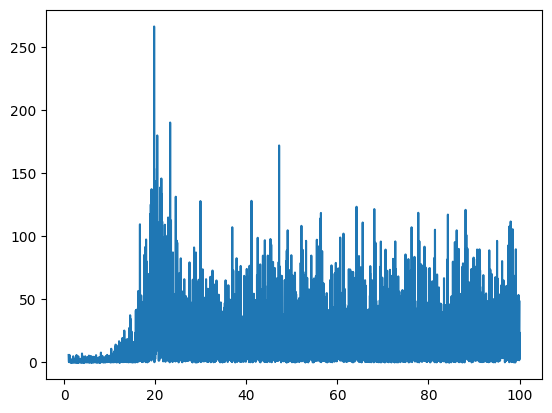

In [76]:
# Limit frequency axis to 1-100 Hz
lower_f_index = np.where(f_bo>1)[0][0]
upper_f_index = np.where(f_bo>100)[0][0]
plt.plot(
    f_bo[lower_f_index:upper_f_index], 
    np.transpose(psd_bo[0, lower_f_index:upper_f_index]))

In [77]:
# Check average power in tail
lower_f_index = np.where(f_bo>50)[0][0]
upper_f_index = np.where(f_bo>100)[0][0]
np.mean(np.transpose(psd_bo[0,lower_f_index:upper_f_index]))

20.040692897430205

## Create Bos-like PSD using Elephant

In [78]:
# Convert binned spike train to an Analog Signal in order to retain the units
f_wbc,psd_wbc = elephant.spectral.welch_psd(
    binned_spikes_timeseries, 
    n_segments=1, 
    window='box')

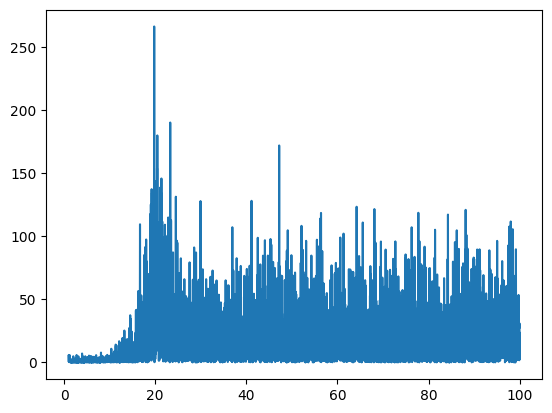

In [79]:
# Limit frequency axis to 1-100 Hz
lower_f_index = np.searchsorted(f_wbc.rescale(pq.Hz).magnitude, 1)
upper_f_index = np.searchsorted(f_wbc.rescale(pq.Hz).magnitude, 100)
plt.plot(f_wbc[lower_f_index:upper_f_index], np.transpose(psd_wbc[0, lower_f_index:upper_f_index]/2))

In [80]:
# Check average power in tail
lower_f_index = np.where(f_wbc>50)[0][0]
upper_f_index = np.where(f_wbc>100)[0][0]
np.mean(np.transpose(psd_wbc[0,lower_f_index:upper_f_index])/2)

array(20.0406929) * 1/Hz

## PSD manually without binning

In [81]:
# This code performing a Fourier transform of delta pulses without binning was supplied by HEP. `fs` is a vector of frequencies for which the
# Fourier integral is evaluated as a sum over the deltas. 
def transform(fs, T, spike_times):
    """Calculate PSD of spike train for given frequencies"""
    s = np.asarray([(sum(np.exp(-1j * 2 * np.pi * f * spike_times/1000. )))
                    * (1. if f==0. else 2.) / (T / 1000.) for f in fs])
    return s

In [82]:
#f_zf = f_w.rescale(pq.Hz).magnitude 
f_zf = np.linspace(0, 500, num=5000)
psd_zf = transform(
    f_zf, 
    duration.rescale(pq.ms).magnitude, 
    st.rescale(pq.ms).magnitude)
psd_zf = np.abs(psd_zf*np.conjugate(psd_zf))

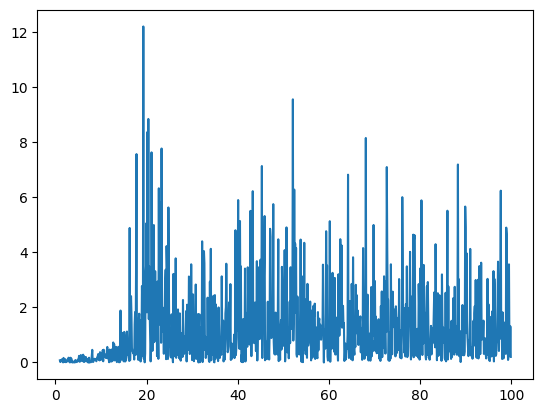

In [83]:
# Limit frequency axis to 1-100 Hz
lower_f_index = np.where(f_zf>1)[0][0]
upper_f_index = np.where(f_zf>100)[0][0]
plt.plot(
    f_zf[lower_f_index:upper_f_index],
    np.transpose(psd_zf[lower_f_index:upper_f_index]))

In [84]:
# Check average power in tail
lower_f_index = np.where(f_zf>50)[0][0]
upper_f_index = np.where(f_zf>100)[0][0]
np.mean(np.transpose(psd_zf[lower_f_index:upper_f_index]))

1.4182482626838242

## Summary

Text(0.5, 0, 'f/Hz')

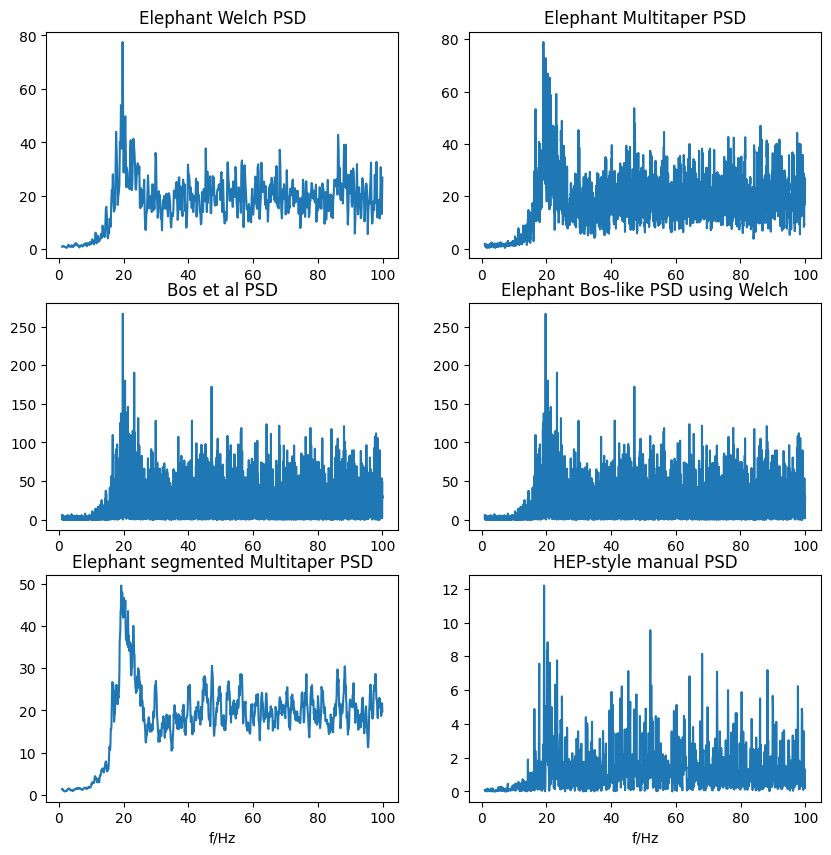

In [85]:
fig, ax = plt.subplots(3,2,figsize=(10,10))
plt.sca(ax[0,0])
lower_f_index = np.searchsorted(f_w.rescale(pq.Hz).magnitude, 1)
upper_f_index = np.searchsorted(f_w.rescale(pq.Hz).magnitude, 100)
plt.plot(f_w[lower_f_index:upper_f_index], np.transpose(psd_w[0, lower_f_index:upper_f_index]/2))
plt.title("Elephant Welch PSD")

plt.sca(ax[0,1])
lower_f_index = np.searchsorted(f_mt.rescale(pq.Hz).magnitude, 1)
upper_f_index = np.searchsorted(f_mt.rescale(pq.Hz).magnitude, 100)
plt.plot(f_mt[lower_f_index:upper_f_index], np.transpose(psd_mt[0, lower_f_index:upper_f_index]/2))
plt.title("Elephant Multitaper PSD")

plt.sca(ax[1,0])
lower_f_index = np.where(f_bo>1)[0][0]
upper_f_index = np.where(f_bo>100)[0][0]
plt.plot(f_bo[lower_f_index:upper_f_index],np.transpose(psd_bo[0, lower_f_index:upper_f_index]))
plt.title("Bos et al PSD")

plt.sca(ax[1,1])
lower_f_index = np.searchsorted(f_wbc.rescale(pq.Hz).magnitude, 1)
upper_f_index = np.searchsorted(f_wbc.rescale(pq.Hz).magnitude, 100)
plt.plot(f_wbc[lower_f_index:upper_f_index], np.transpose(psd_wbc[0, lower_f_index:upper_f_index]/2))
plt.title("Elephant Bos-like PSD using Welch")

plt.sca(ax[2,0])
lower_f_index = np.searchsorted(f_mtn.rescale(pq.Hz).magnitude, 1)
upper_f_index = np.searchsorted(f_mtn.rescale(pq.Hz).magnitude, 100)
plt.plot(f_mtn[lower_f_index:upper_f_index], np.transpose(psd_mtn[0, 0, lower_f_index:upper_f_index]/2))
plt.title("Elephant segmented Multitaper PSD")
plt.xlabel("f/Hz")

plt.sca(ax[2,1])
lower_f_index = np.where(f_zf>1)[0][0]
upper_f_index = np.where(f_zf>100)[0][0]
plt.plot(f_zf[lower_f_index:upper_f_index],np.transpose(psd_zf[lower_f_index:upper_f_index]))
plt.title("HEP-style manual PSD")
plt.xlabel("f/Hz")